In [134]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Replace
$$y = mx * b$$
with
$$y = \theta_0 + \theta_1 x$$

So that when we have a multivariate case, we can writ something like,
$$y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ...$$

##  One variable

[1.90121727 0.31438759]
Slope =  1.9012172673220806
Intercept =  0.3143875934705495


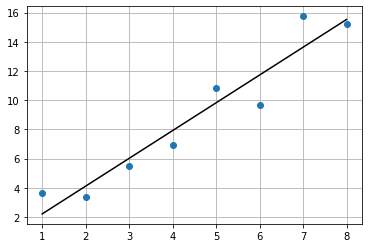

In [135]:
np.random.seed(1)

x = np.array([1,2,3,4,5,6,7,8])
y = 2 * x + np.random.normal(0, 1, size = x.size)

plt.plot(x, y, 'o')
plt.grid(True)

#  I am using the polyfit function to do the regression.  In the past, we've used 
#  A function from scipy.stats.
#  This will allow us to check the results from our algorithm.
p = np.polyfit(x, y, 1); print(p)
plt.plot(x, p[0] * x + p[1], 'k')
print('Slope = ', p[0])
print('Intercept = ', p[1])

x.shape = (x.size, 1)
ones = np.ones( x.shape )

y.shape = (y.size, 1)
X = np.hstack( (ones, x) )

###  Previous Gradient Calculation
In the original gradient descent video, we wrote the gradient as,
$$\frac{\partial J}{\partial \theta_1} =  \sum_i -2x_i (y_i - \theta_1 x_i - \theta_0)$$
$$\frac{\partial J}{\partial \theta_0} =  \sum_i -2 (y_i - \theta_1 x_i - \theta_0)$$

Can we write this in a more compact way?

Define:
$$
\begin{array}{ll}
    \Theta = \left(
       \begin{array}{l}
           \theta_0 \\
           \theta_1
       \end{array} \right)
       &
       X = \left(
       \begin{array}{l}
           1 \\
           x_i
       \end{array} \right)
\end{array}
$$
What os the dot product $\Theta \cdot X$?

$$
\begin{array}{ll}
    \Theta \cdot X = \Theta^\dagger X = &
    (\theta_0 \quad \theta_1)
    \left(
    \begin{array}{l}
        1 \\
        x_i
    \end{array} \right)
\end{array}
$$
The above matrix product is equal to:
$$
\theta_0 + \theta_1 x_i
$$
This is the equation of a line.

Consider the matrix equation,
$$
\underbrace{
    (
    \begin{array}{cc}
        a & b\\
    \end{array}
)
}_u
\left(
    \begin{matrix}
        a & c & e & g \\
        b & d & f & h
    \end{matrix}
   \right)
$$

Let's define the following:
$$
\begin{array}{lllll}
    v_1 = \left(
    \begin{array}{l}
        a \\ b
    \end{array}\right) , & 
    v_2 = \left(
    \begin{array}{l}
        a \\ b
    \end{array}\right) , & 
     v_3 = \left(
    \begin{array}{l}
        c \\ d
    \end{array}\right) , & 
     v_4 = \left(
    \begin{array}{l}
        e \\ f
    \end{array}\right),  & 
    v_5 = \left(
    \begin{array}{l}
        g \\ h
    \end{array}\right)
\end{array}
$$

So the matrix product gives a row vector whose entries are the dot prouct of $u$ with each column of the second matrix.
$$
\left(
\begin{array}{lllll}
    (u \cdot v_1) & 
    (u \dot v_2) & 
    (u \cdot v_3) & 
    (u \cdot v_4) & 
    (u \cdot v_5)
\end{array}
\right)
$$

###  Here is our gradient descent function

In [136]:
#  Our gradient descent implementation.  For the time being, there is no cutoff criteria other than reaching max count
#  fprime is the function which returns the derivative or gradient
# x0 is out initial guess for the minimum
def gradient_descent(fprime, x0, args = None, gamma = 1e-3, max_iter = 1e5, debug = False, f = None):
    count = 0

    if f:
        J = np.zeros( (int(max_iter) + 2, ) )
        J[count] = f(x0, args)
        
        if isinstance(x0, float) or isinstance(x0, int):
            X = np.zeros( (int(max_iter) + 2, ) )
        else:
            if x0.ndim == 1 and x0.size > 1:
                X = np.zeros( (int(max_iter) + 2, x0.size) )
        
        X[count] = x0
        
    while count < max_iter:
        count = count + 1
        
        x0 = x0 - gamma * fprime(x0, args)
        if debug == True:
            X[count] = x0
            J[count] = f(x0, args)
    
    if debug == True:
        return x0, count, X, J
    else:
        return x0, count
    

These are the cost function and gradient from the previous videos. We can use them to check our new code.

In [137]:
def linear_regression_cost_function_old(x0, x, y):
    m = x0[0]
    b = x0[1]
    
    return np.sum( np.square( (y - (m*x + b)) ) )

def linear_regression_gradient_old(x0, args):
    x = args[0]
    y = args[1]
    
    m = x0[0]
    b = x0[1]

    Fp1 = np.sum(2 * (y - m*x -b) * (-x))
    Fp2 = np.sum(2 * (y - m * x - b) * ( -1))
    
    return np.array( [Fp1, Fp2] )

Let's build our new, fully vectorized functions.

In [138]:
def linear_regression_cost_function(theta, x, y):
    x = x.T
    
    J = np.sum( np.square(y.T - np.matmul(theta.T, x) ) )
    
    return J

def linear_regression_gradient(theta, arg):
    x = args[0]
    y = args[1]
    
    x = x.T
    grad = (y.T - np.matmul(theta.T, x))
    #grad = np.vstack( (grad, grad) )

    grad = np.multiply(-2 * x, grad)

    grad = np.sum(grad, axis = 1)
    
    grad.shape = (grad.size, 1)
    
    return grad

In [139]:
#  Our initial guesses for theta.  Remember we want to recast it as a column vector.
theta = np.array( [1, 1] )
theta.shape  = (2, 1)

#  Compare values from the old and new functions.
#print( linear_regression_cost_function_old(theta, x, y))
#print( linear_regression_cost_function(theta, X, y))

#print( linear_regression_gradient_old(theta, (x, y)) )

args = (X, y)
#print( linear_regression_gradient(theta, args) )

#  Run gradient descent using our new functions to get the slope and intercept.
theta, count = gradient_descent(linear_regression_gradient, theta)
print(theta)

[[0.31438759]
 [1.90121727]]


##  2-d (planar) fit
Define and plot points that line in a plane.

In [140]:
np.random.seed(2)
x = np.random.randint(-10, 11, size=(20,1))
y = np.random.randint(-10, 11, size=(20,1))

z = 0.5 * x - 0.75 * y - 2

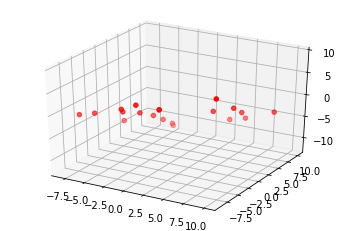

In [141]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o')

In [143]:
ones = np.ones( (x.size, 1) )
X = np.hstack( (ones, x, y)  )
theta = np.array( [1, 1, 1,] ); theta.shape = (3, 1)

#  Call our gradient descent using the same linear regression functions defined above.
args = (X, z)
theta, count = gradient_descent(linear_regression_gradient, theta, args = args)
print(theta)

[[-2.  ]
 [ 0.5 ]
 [-0.75]]
